In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# for data vis

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

# ! if  ! ( pip freeze | grep -E "datasets" ) ; then pip install datasets; fi
# %pip install bitsandbytes
# import bitsandbytes

# from datasets import Dataset

import torch 
from torch import nn, Tensor
from torch.utils.data import DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

from tqdm import tqdm #prog bar

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

MAX_LENGTH = 512

/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv
/kaggle/input/aes2-deberta-engessay-features/val_features.csv
/kaggle/input/aes2-deberta-engessay-features/train_features.csv


# Set Device

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Read data

In [24]:
DATA_DIR = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"
df = pd.read_csv(DATA_DIR + "train.csv")
test_df = pd.read_csv(DATA_DIR + 'test.csv')

print("# Train Data: {:,}".format(len(df)))
print("# Sample:")
display(df.head(2))

# Train Data: 17,307
# Sample:


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3


# Data split

In [25]:
from sklearn.model_selection import train_test_split  # Import package

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["score"], random_state=42)

/tmp/ipykernel_34/2566460747.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


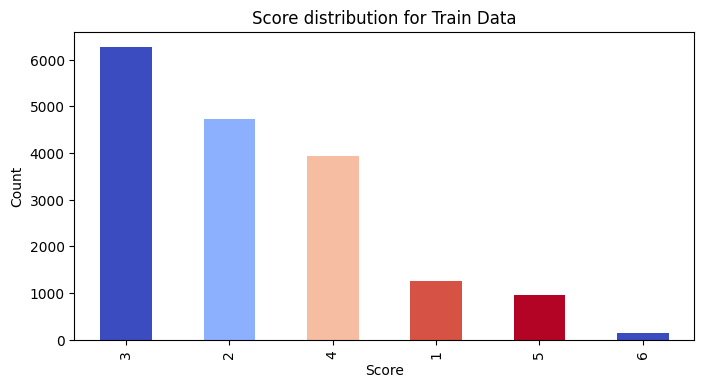

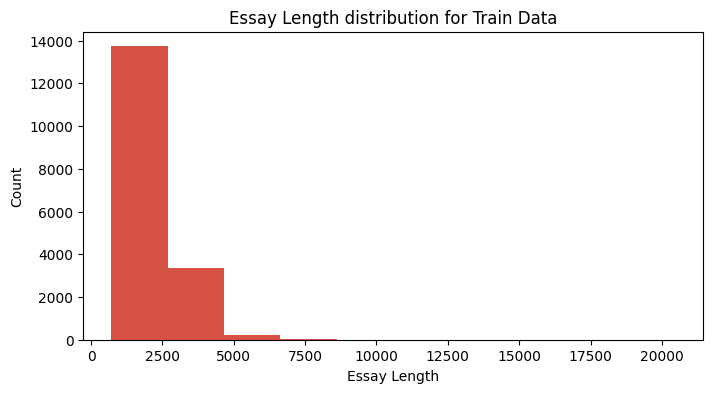

In [26]:
cmap = mpl.cm.get_cmap('coolwarm')

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.score.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score distribution for Train Data")
plt.show()

# Show distribution of essay length using a bar plot
plt.figure(figsize=(8, 4))
df['essay_length'] = df.full_text.map(len)
df.essay_length.plot.hist(logy=False, color=cmap(0.9))
plt.xlabel("Essay Length")
plt.ylabel("Count")
plt.title("Essay Length distribution for Train Data")
plt.show()

# Define Metric QWK

## Quadratic Weighted Kappa Score

In [27]:
# thanks will x2
def quadratic_weighted_kappa(preds, actuals):
    penalty_by_diff = np.array([0, 0.04, 0.16, 0.36, 0.64, 1])
    return sum(penalty_by_diff[torch.abs(preds - actuals).to(torch.int32)])

In [28]:
def tensor_QWK(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    assert y_true.shape == y_pred.shape
    y_true = y_true.cpu().detach()
    y_pred = y_pred.cpu().detach()
    return quadratic_weighted_kappa(y_true, y_pred)

## Define Features Dataset with Engessay model breakdowns

In [29]:
import torch

class FeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, breakdown, scores):
        self.breakdown = breakdown
        self.scores = np.array(scores)
    
    def __getitem__(self, index):
        breakdown = torch.tensor(self.breakdown[index])  # Convert to tensor
        score = self.scores[index]
        return breakdown, score
 
    def __len__(self):
        return len(self.breakdown)

In [30]:
import torch

class FeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, breakdown, scores):
        self.breakdown = np.array(breakdown, dtype=np.float32)
        self.scores = np.array(scores, dtype=np.float32)
    
    def __getitem__(self, index):
        breakdown = torch.tensor(self.breakdown[index])  # Convert to tensor
        score = self.scores[index]
        return breakdown, score
 
    def __len__(self):
        return len(self.breakdown)

In [31]:
# Define function to create FeaturesDataset from DataFrame
def create_features_dataset_from_df(df):
    # Extract breakdowns and scores from DataFrame
    combined_breakdowns = df.iloc[:, :-1].values  # Exclude the last column (scores)
    scores = df["scores"].values

    # Create FeaturesDataset object
    features_dataset = FeaturesDataset(combined_breakdowns, scores)
    return features_dataset


In [32]:
engessay_feature_names = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar",  "conventions"]

In [33]:
train_features_df = pd.read_csv("/kaggle/input/aes2-deberta-engessay-features/train_features.csv", index_col=0)
val_features_df = pd.read_csv("/kaggle/input/aes2-deberta-engessay-features/val_features.csv", index_col=0)

In [34]:
# Create FeaturesDataset objects for train and validation sets
train_features_ds = create_features_dataset_from_df(train_features_df)
val_features_ds = create_features_dataset_from_df(val_features_df)

# XG Boost model

In [60]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score

# Assuming train_features_ds and val_features_ds are already defined

X_train = train_features_ds.breakdown
y_train = train_features_ds.scores

X_val = val_features_ds.breakdown
y_val = val_features_ds.scores

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'gamma': [0, 0.1, 1.0]
}

# Create an XGBoost regressor model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the validation set
y_pred = best_model.predict(X_val)

# Round the predictions to the nearest integer (assuming scores are integers)
y_pred_rounded = np.round(y_pred).astype(int)

# Compute mean squared error
mse = mean_squared_error(y_val, y_pred_rounded)
print(f'Mean Squared Error on Validation Set: {mse:.4f}')

# Compute accuracy
accuracy = accuracy_score(y_val, y_pred_rounded)
print(f'Accuracy on Validation Set: {accuracy:.4f}')

# Print best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Mean Squared Error on Validation Set: 0.3914
Accuracy on Validation Set: 0.6612
Best Parameters: {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1}


In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'Root Mean Squared Error: {rmse:.4f}')

# Round the predictions to the nearest integer
y_pred_rounded = np.round(y_pred).astype(int)

# Calculate accuracy
correct_predictions = np.sum(y_pred_rounded == y_test)
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy:.2%}')

# MLP Classifier

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torch.nn.functional as F

# Define the MLP model with multiple hidden layers
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPClassifier, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))  # Input layer to first hidden layer
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))  # Hidden layers
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)  # Last hidden layer to output layer
        
    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))  # Apply ReLU activation to each hidden layer
        x = self.output_layer(x)
        return x

In [45]:
# Create DataLoader
batch_size = 32
dataloader = DataLoader(train_features_ds, batch_size=batch_size, shuffle=True)


In [46]:
# Assuming val_features_ds is the validation FeaturesDataset
val_dataloader = DataLoader(val_features_ds, batch_size=batch_size, shuffle=False)

# Evaluate the model on the validation set
correct_predictions = 0
total_predictions = 0

# Set model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    for features, labels in val_dataloader:
        # Convert labels to long tensor (required for CrossEntropyLoss)
        labels = labels.long() - 1  # Assuming scores are 1-6, subtract 1 for 0-based indexing
        
        # Forward pass
        outputs = model(features)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Compute accuracy
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Compute accuracy
val_accuracy = correct_predictions / total_predictions
print(f'Validation Accuracy: {val_accuracy:.2%}')

Validation Accuracy: 65.80%


In [47]:
# Assuming val_features_ds is the validation FeaturesDataset
val_dataloader = DataLoader(val_features_ds, batch_size=batch_size, shuffle=False)


In [56]:
# Model parameters
input_size = train_features_ds.breakdown.shape[1]  # Number of features
hidden_sizes = [256, 128, 64]
output_size = 6  # Number of classes (assuming scores are from 1 to 6)

# Initialize model, loss function, and optimizer
model = MLPClassifier(input_size, hidden_sizes, output_size)

Epoch [1/200], Train Loss: 0.6387, Train Acc: 0.7398, Val Loss: 0.8555, Val Acc: 0.6537
Epoch [2/200], Train Loss: 0.5833, Train Acc: 0.7580, Val Loss: 0.8186, Val Acc: 0.6560
Epoch [3/200], Train Loss: 0.5767, Train Acc: 0.7628, Val Loss: 0.8205, Val Acc: 0.6511
Epoch [4/200], Train Loss: 0.5710, Train Acc: 0.7621, Val Loss: 0.8315, Val Acc: 0.6459
Epoch [5/200], Train Loss: 0.5714, Train Acc: 0.7635, Val Loss: 0.8230, Val Acc: 0.6644
Epoch [6/200], Train Loss: 0.5706, Train Acc: 0.7642, Val Loss: 0.8596, Val Acc: 0.6493
Epoch [7/200], Train Loss: 0.5679, Train Acc: 0.7662, Val Loss: 0.8337, Val Acc: 0.6508
Epoch [8/200], Train Loss: 0.5675, Train Acc: 0.7644, Val Loss: 0.8602, Val Acc: 0.6574
Epoch [9/200], Train Loss: 0.5689, Train Acc: 0.7655, Val Loss: 0.8539, Val Acc: 0.6398
Epoch [10/200], Train Loss: 0.5669, Train Acc: 0.7645, Val Loss: 0.8437, Val Acc: 0.6574
Epoch [11/200], Train Loss: 0.5641, Train Acc: 0.7650, Val Loss: 0.8588, Val Acc: 0.6603
Epoch [12/200], Train Loss: 0.

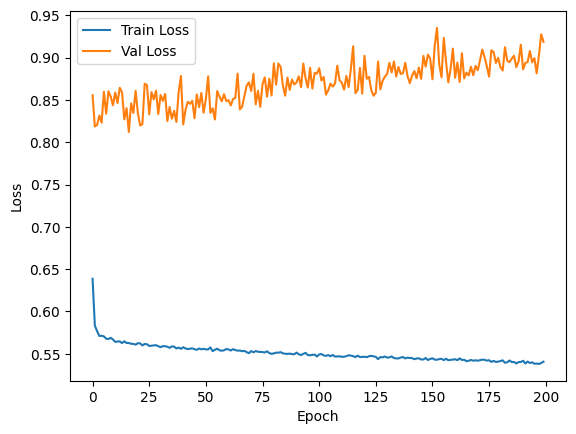

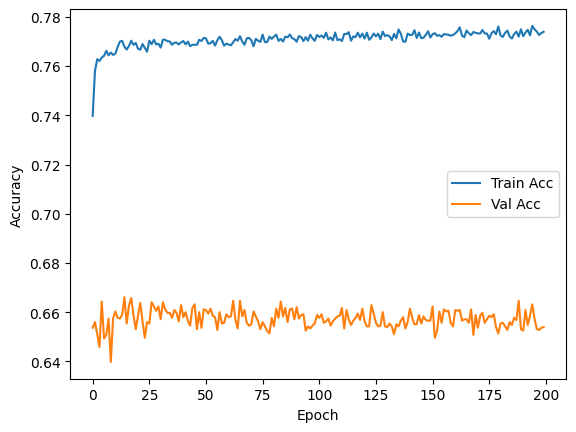

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set model to training mode
    train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for features, labels in dataloader:
        labels = labels.long() - 1
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * features.size(0)  # Accumulate the loss
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.size(0)
    train_loss /= len(dataloader.dataset)  # Compute average training loss
    train_losses.append(train_loss)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    for features, labels in val_dataloader:
        labels = labels.long() - 1
        outputs = model(features)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * features.size(0)  # Accumulate the loss
        _, predicted = torch.max(outputs, 1)
        correct_val_predictions += (predicted == labels).sum().item()
        total_val_predictions += labels.size(0)
    val_loss /= len(val_dataloader.dataset)  # Compute average validation loss
    val_losses.append(val_loss)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_accuracies.append(val_accuracy)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:

# Get the index of the minimum validation loss
best_loss_index = np.argmin(val_losses)
# Retrieve the best validation loss
best_val_loss = val_losses[best_loss_index]

# Get the index of the maximum validation accuracy
best_acc_index = np.argmax(val_accuracies)
# Retrieve the best validation accuracy
best_val_acc = val_accuracies[best_acc_index]

print(f'Best Validation Loss: {best_val_loss:.4f}')
print(f'Best Validation Accuracy: {best_val_acc:.4f}')

Best Validation Loss: 0.8121
Best Validation Accuracy: 0.6661
